Exploratory Data Analysis for a CVS file saved from the query

https://stat.hel.fi:443/sq/e12ebf8e-7eb8-4903-9998-31e68e131488

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns

# In case you're running Python 3.9 (as yours truly is), you might wish to suppress
# deprecation warnings produced when running an old Seaborn release together with
# a (fairly) recend Pandas release. The two lines below accomplish exactly that.
import warnings
warnings.filterwarnings('ignore')

In [118]:
# stat.helsinki.fi produces LATIN-1 encoded CSV (JSON is even more screwed).
csv_data = pd.DataFrame(pd.read_csv('taxable_income_per_person_in_national_taxes.csv',
                                    encoding = 'latin1'))

Data cleanup reasons:
- GeoJSON data for city district borders refers districts by their numbers.
- Plotting requires numeric types.
- Averages are useful, perhaps, when doing preditions.

In [119]:
# Simplify column names "NNNN Valtionveronalaiset tulot ... blah" -> "NNNN"
df = csv_data.rename(columns = { _: _.split()[0] for _ in csv_data.columns if 'veronalaiset' in _ })

# Convert income columns into numeric types.
for _ in [ str(i) for i in range(1993, 2018) ]:
  df[_] = pd.to_numeric(df[_], errors = 'coerce')

# Drop any collections of districts ("peruspiiri", "suurpiiri", etc.).
df = df[df['Alue'].str.contains('piiri') == False]

# Pick out the global averages and drop them out.
averages = df.loc[df['Alue'] == '091 Helsinki']
averages.drop('Alue', axis = 1, inplace = True)
df.drop(df.loc[df['Alue'] == '091 Helsinki'].index, inplace = True)

# Strip anything but the city district numbers from the column "Alue".
df['Alue'] = df['Alue'].map(lambda _: int(str(_).split()[1]))

# Drop all rows with NULL values as filling with them with the mean would not
# really tell us much about changes in affluence (difference of mean with mean is,
# obviously, just 0).
df.dropna(inplace = True)

In [120]:
print(averages)

print(df.query('10 <= Alue <= 20'))

      1993     1994     1995     1996     1997     1998     1999     2000  \
0  14424.0  14507.0  15026.0  15563.0  16475.0  17690.0  19601.0  21529.0   

      2001     2002  ...     2008     2009     2010     2011     2012  \
0  21284.0  21748.0  ...  25882.0  27891.0  26790.0  27512.0  27897.0   

      2013     2014     2015     2016     2017  
0  28886.0  29197.0  29898.0  30030.0  30972.0  

[1 rows x 25 columns]
   Alue     1993     1994     1995     1996     1997     1998     1999  \
3    10  18140.0  18565.0  19057.0  19997.0  22559.0  24689.0  29522.0   
4    20  18888.0  17948.0  20687.0  19298.0  21942.0  21744.0  31807.0   

      2000     2001  ...     2008     2009     2010     2011     2012  \
3  35251.0  31655.0  ...  36784.0  37730.0  37081.0  37944.0  38798.0   
4  30197.0  28675.0  ...  38110.0  43743.0  40950.0  42679.0  41599.0   

      2013     2014     2015     2016     2017  
3  39770.0  42052.0  49045.0  43005.0  44080.0  
4  50242.0  56643.0  63849.0  81033.

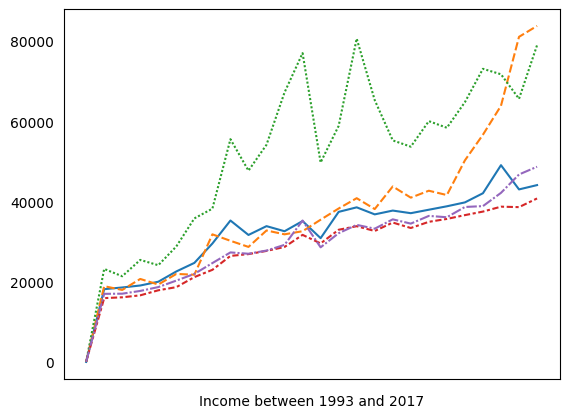

In [121]:
_ = sns.lineplot(data = df.query('10 <= Alue <= 50').T, legend = False)
_.set(xlabel = 'Income between 1993 and 2017')
_.set(xticklabels = [])
_.tick_params(bottom = False, left = False)

In [191]:
average_deltas = pd.DataFrame(
  columns = [ f'{averages.columns[c-1]}-{averages.columns[c]}' for c in range(1, len(averages.columns)) ],
  data = [
    [ 
      float((averages.iloc[0:1, c] - averages.iloc[0:1, c - 1]))
      for c in range(1, len(averages.columns))
    ]
  ]
)

deltas = pd.DataFrame(
  columns = [ 'Alue' ] + [ f'{df.columns[c-1]}-{df.columns[c]}' for c in range(2, len(df.columns)) ],
  data = [
      [ df.iloc[r:r + 1, 0].values[0] ] +
      [
        (df.iloc[r:r + 1, c].values[0] - df.iloc[r:r + 1, c - 1].values[0]) -
        average_deltas.iloc[0:1, 0].values[0]
        for c in range(2, len(df.columns))
      ]
      for r in range(0, len(df.index))
  ]
)

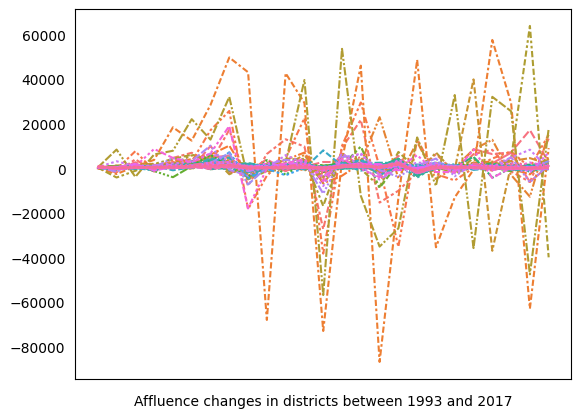

In [192]:
_ = sns.lineplot(data = deltas.T, legend = False)
_.set(xlabel = 'Affluence changes in districts between 1993 and 2017')
_.set(xticklabels = [])
_.tick_params(bottom = False, left = False)

Differences between average year-on-year income changes and changes in income year-on-year in every district has quite a scale. Normalizing values onto the interval (-1, 1) gives us a nice way to visualise with (pretty much) any JavaScript concoction with two base hues -- say blue for negative correlation and red for positive correlation -- and opacity changes as opacity on JavaScript canvas sits on the interval [0,1].

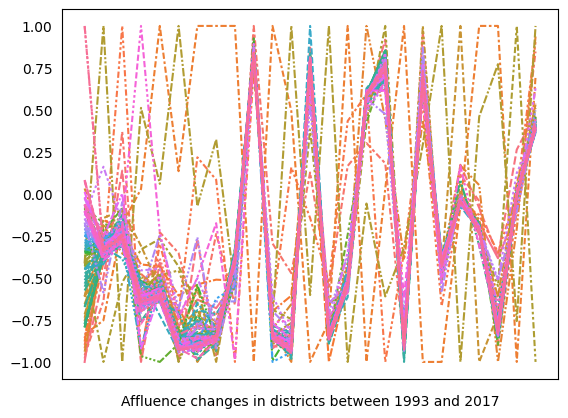

In [200]:
from sklearn.preprocessing import MinMaxScaler

ndeltas = MinMaxScaler(feature_range = (-1, 1)).fit_transform(deltas)

_ = sns.lineplot(data = ndeltas.T, legend = False)
_.set(xlabel = 'Affluence changes in districts between 1993 and 2017')
_.set(xticklabels = [])
_.tick_params(bottom = False, left = False)